In [78]:
import pandas as pd

data = pd.read_csv("SBER 1h.csv")

data.begin = pd.to_datetime(data.begin)
data.end = pd.to_datetime(data.end)

In [79]:
from catboost import CatBoostClassifier

train_data = data[data.begin < pd.to_datetime("2023-01-01 00:00:00")]
test_data = data[data.begin >= pd.to_datetime("2023-01-01 00:00:00")]


1.002 0.5 0.7581364182842539
1.002 0.6 0.9098399899240808
1.002 0.7 0.9679760609643286
1.002 0.8 1.0372800403539115
1.002 0.9 1.0036043217280002
1.003 0.5 0.9585828795287675
1.003 0.6 1.0265737155881542
1.003 0.7 1.0336285167956898
1.003 0.8 1.012496583436168
1.003 0.9 0.9952439760172269
1.005 0.5 1.1193852842773515
1.005 0.6 1.0609013483698948
1.005 0.7 1.024422478448231
1.005 0.8 1.0415645873187798
1.005 0.9 1.012652994088
1.01 0.5 1.0263846055157386
1.01 0.6 1.01909356274646
1.01 0.7 1.0320002811745836
1.01 0.8 1.0278546986880004
1.01 0.9 1.0092


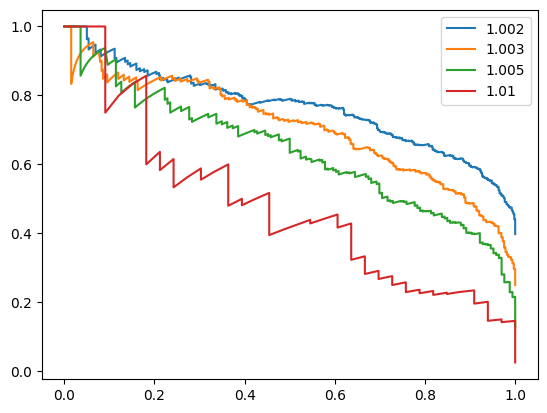

In [81]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Classifier trained on same profit threshold that will be in test data. Yields are poor.
commission = 0.0008
for req_increase in [1.002, 1.003, 1.005, 1.01]:
    X_train = train_data[['open', 'close', 'high', 'low', 'value', 'volume']]
    Y_train = train_data.high > train_data.open * req_increase
    Y_train.shift()

    model = CatBoostClassifier()
    model.fit(X_train, Y_train, verbose=False)

    X_test = test_data[['open', 'close', 'high', 'low', 'value', 'volume']]
    Y_test = test_data.high > test_data.open * req_increase
    Y_test.shift()

    y_pred = model.predict_proba(X_test)
    precision, recall, _ = precision_recall_curve(Y_test, y_pred[:, 1])
    plt.plot(recall, precision)
    for required_certainity in [0.5, 0.6, 0.7, 0.8, 0.9]:

        balance = 1

        for i in range(Y_test.shape[0]):
            if Y_test.iloc[i] and y_pred[i, 1] > required_certainity:
                balance *= req_increase - commission # substract the commission for 2 trades
            if Y_test.iloc[i] == 0 and y_pred[i, 1] > required_certainity:
                balance *= (X_test.iloc[i]['close'] / X_test.iloc[i]['open']) - commission

        print(req_increase, required_certainity, balance)
plt.legend([1.002, 1.003, 1.005, 1.01])

1.002 0.5 0.7581364182842539
1.002 0.6 0.9098399899240808
1.002 0.7 0.9679760609643286
1.002 0.8 1.0372800403539115
1.002 0.9 1.0036043217280002
1.003 0.5 0.7458898112196759
1.003 0.6 0.9524259011192482
1.003 0.7 1.0329692919626645
1.003 0.8 1.0410068012503249
1.003 0.9 1.0066145306479999
1.005 0.5 0.8372024043559385
1.005 0.6 1.0964764968251897
1.005 0.7 1.1572602732820232
1.005 0.8 1.115882942508324
1.005 0.9 1.012652994088
1.01 0.5 0.8715822069528623
1.01 0.6 1.1612435153894878
1.01 0.7 1.267535523156208
1.01 0.8 1.204024207463473
1.01 0.9 1.022795773834952


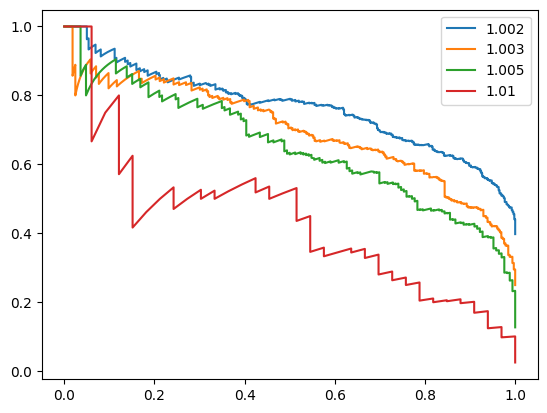

In [82]:
# Classifier trained to give signal when there's an opportunity for a minimal profit.
# Yields are better.
X_train = train_data[['open', 'close', 'high', 'low', 'value', 'volume']]
Y_train = train_data.high > train_data.open * 1.002
Y_train.shift()

model = CatBoostClassifier()
model.fit(X_train, Y_train, verbose=False)

for req_increase in [1.002, 1.003, 1.005, 1.01]:

    X_test = test_data[['open', 'close', 'high', 'low', 'value', 'volume']]
    Y_test = test_data.high > test_data.open * req_increase
    Y_test.shift()

    y_pred = model.predict_proba(X_test)
    precision, recall, _ = precision_recall_curve(Y_test, y_pred[:, 1])
    plt.plot(recall, precision)
    for required_certainity in [0.5, 0.6, 0.7, 0.8, 0.9]:

        balance = 1

        for i in range(Y_test.shape[0]):
            if Y_test.iloc[i] and y_pred[i, 1] > required_certainity:
                balance *= req_increase - commission # substract the commission for 2 trades
            if Y_test.iloc[i] == 0 and y_pred[i, 1] > required_certainity:
                balance *= (X_test.iloc[i]['close'] / X_test.iloc[i]['open']) - commission

        print(req_increase, required_certainity, balance)
plt.legend([1.002, 1.003, 1.005, 1.01])